In [1]:
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring, bitstring_to_bytes, bitstring_to_int

In [2]:
import multihash as mh
import hashlib as hl  

def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [3]:
import csv

filename = "nebula-peers.csv"

In [4]:
with open(filename, 'r') as file:
    nebula_peers = [line for line in csv.reader(file)]

In [5]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        self.neighbors[bytes_to_bitstring(peer.key)]=(peer)
        self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)
    

In [6]:
peers = {line[0]: NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers}

In [7]:
# define neighbor relationships
for p in peers:
    for n in peers[p].neighbors_ids:
        peers[p].addNeighbor(peers[n])

In [8]:
buckets=[[] for _ in range(257)]

for pid in peers:
    p=peers[pid]
    if p.alive:
        for i in range(len(p.buckets)):
            buckets[i].append(len(p.buckets[i]))


In [9]:
import matplotlib.pyplot as plt

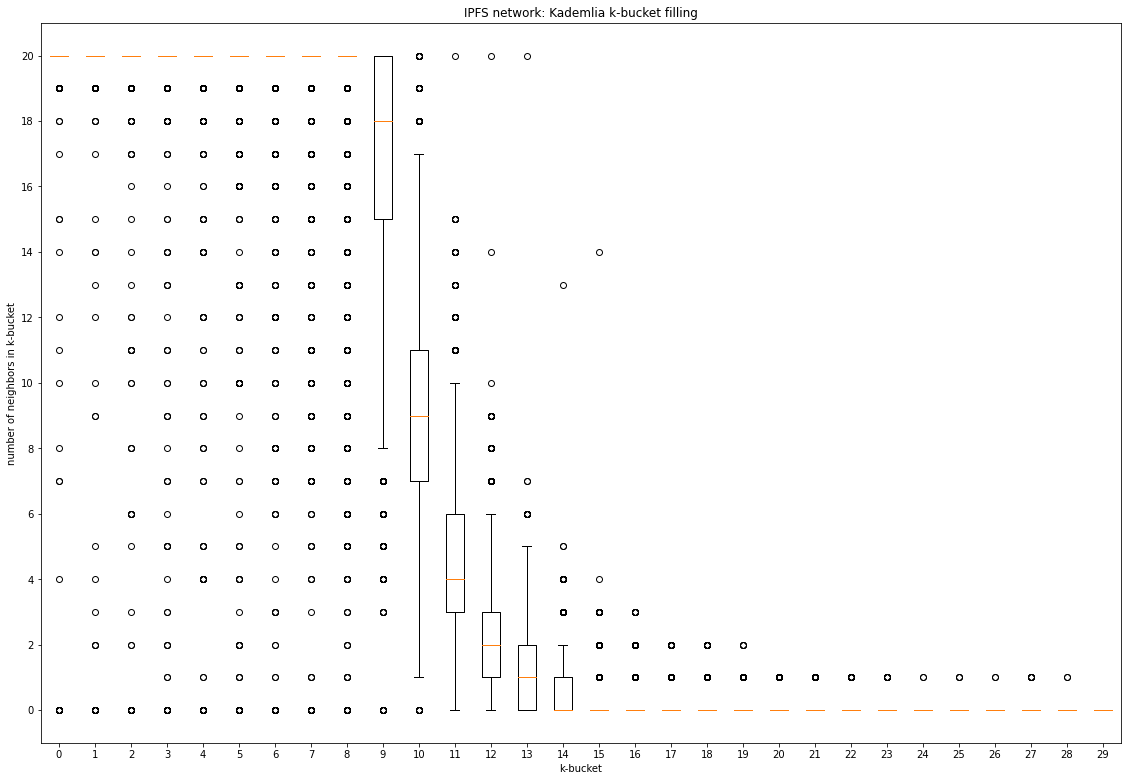

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))

plt.xlabel("k-bucket")
plt.ylabel("number of neighbors in k-bucket")

plt.title("IPFS network: Kademlia k-bucket filling")

_= ax.boxplot(buckets[:30], positions=range(0,30))
 
# show plot
plt.show()

In [18]:
t = Trie()
for p in peers:
    t.add(bytes_to_bitstring(peers[p].key), metadata=peers[p])

## 20 closest peers CDF

In [12]:
alive_peers = {line[0]: NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers if len(line)>2}

In [13]:
alive_trie = Trie()
for p in alive_peers:
    alive_trie.add(bytes_to_bitstring(alive_peers[p].key), metadata=alive_peers[p])

In [46]:
neighbors20 = []
for p in alive_peers:
    peers20 = alive_trie.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:]
    # peerset20 = t.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:] # that is wrong
    # we should test the actual neighbors e.g peers[p].neighbors
    neighbors = [peers[p].neighbors[n].key for n in peers[p].neighbors]
    
    count = 0
    for p in peers20:
        if p.key in neighbors:
            count+=1
    neighbors20.append(count)


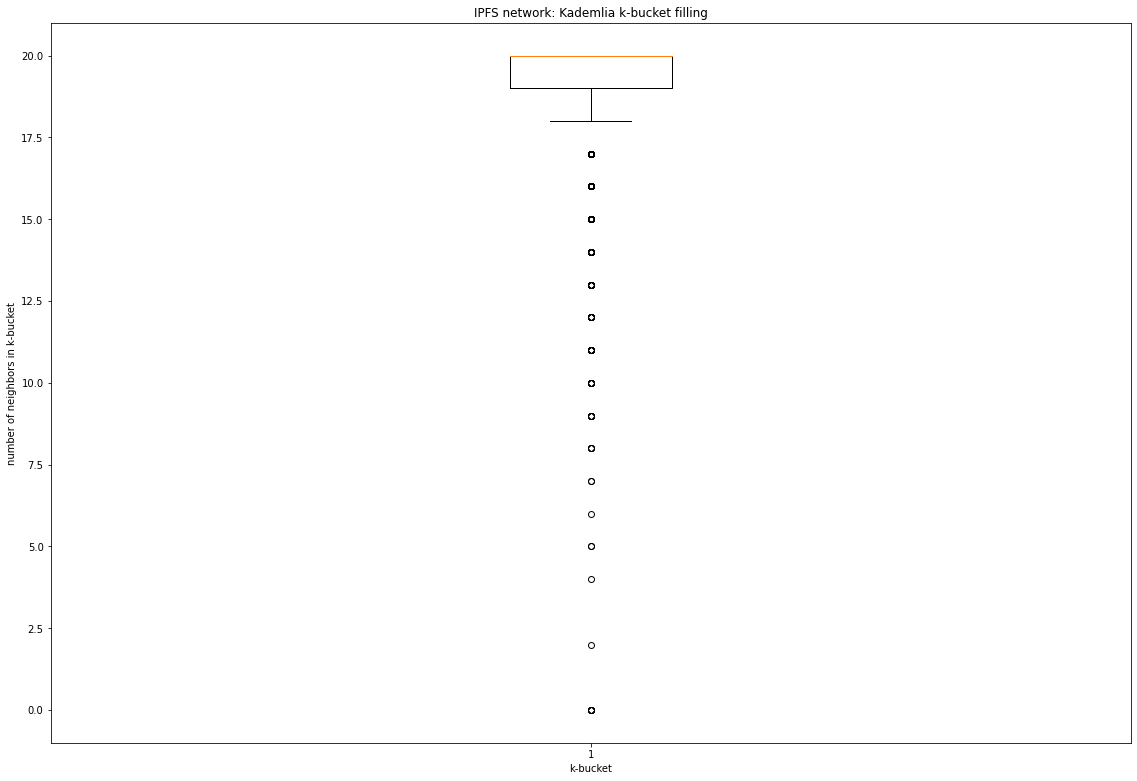

In [40]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
#plt.yticks(range(0, 21, 2))

plt.xlabel("k-bucket")
plt.ylabel("number of neighbors in k-bucket")

plt.title("IPFS network: Kademlia k-bucket filling")

_= ax.boxplot(neighbors20)
 
# show plot
plt.show()

In [63]:
cc = 0
for n in neighbors20:
    if n==20:
        cc+=1
cc/len(neighbors20)

0.5925497752087348

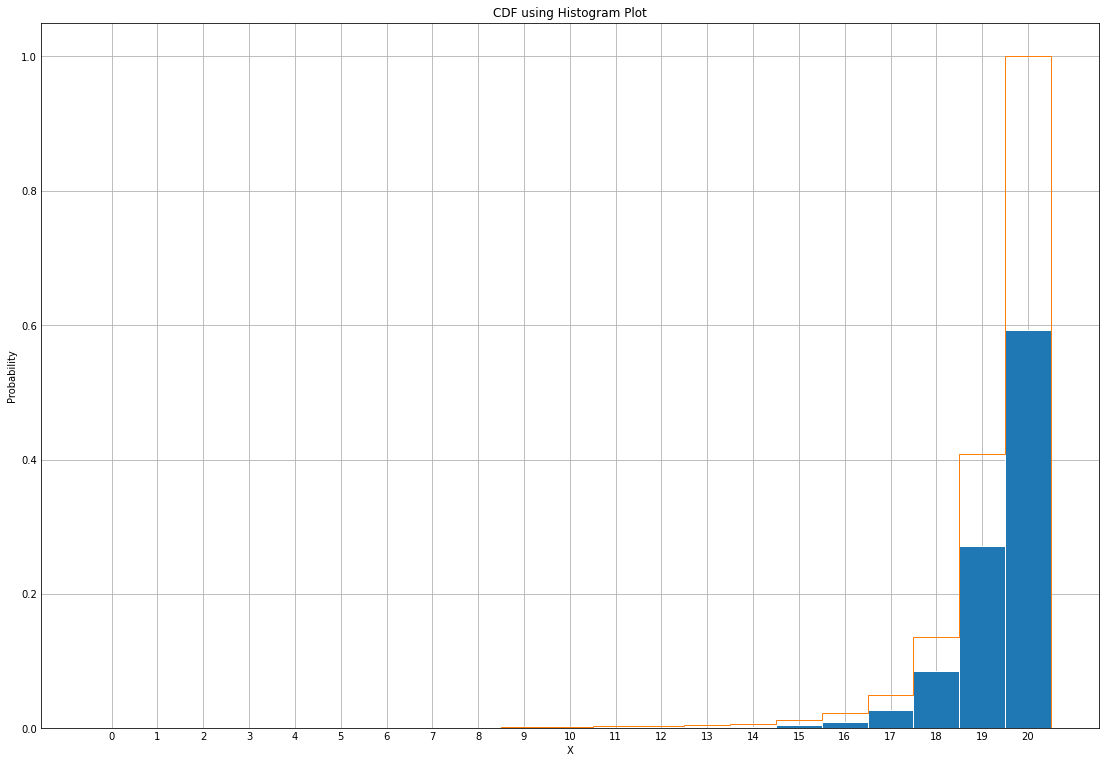

In [66]:
import numpy as np

plt.figure(figsize=(15,10))
plt.hist(neighbors20,bins=[x - 0.5 for x in range(0,22)],density=True, linewidth=1, edgecolor="white")
#plt.hist(neighbors20,bins=20,density=True)
plt.hist(neighbors20,bins=[x - 0.5 for x in range(0,22)], density=True, cumulative=True, label='CDF', histtype='step')
plt.xlabel("X")
plt.ylabel("Probability")
plt.xticks(np.arange(0,21))
plt.title("CDF using Histogram Plot")
plt.show()

In [29]:
count = 0
count1 = 0
for p in alive_peers:
    peer20 = alive_trie.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[-1]
    peerset20 = alive_trie.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:]
    
    if 
    
    distance = alive_peers[p].distance(peer20)
    for peer in peerset20:
        if not alive_peers[p].distance(peer) <= distance:
            count += 1
count

0

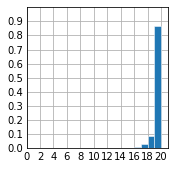

<Figure size 1080x720 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data
np.random.seed(1)
x = 4 + np.random.normal(0, 1.5, 200)

# plot:
fig, ax = plt.subplots()

ax.hist(neighbors20,bins=20,density=True, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 21), xticks=np.arange(0, 21,2),
       ylim=(0, 1), yticks=np.arange(0, 1, 0.1))

plt.figure(figsize=(15,10))
plt.show()